In [8]:
from src.utils import *

c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
c:\Users\ubach\Projects\GQA\src\utils.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/

In [9]:
# Load required libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import fiona
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from shapely.ops import unary_union
from shapely.errors import TopologicalError
from unidecode import unidecode
import glob
import csv
from datetime import datetime
import dask.dataframe as dd
import dask_geopandas as dg
from dask.distributed import Client
import gc
import re

In [10]:
# Path to data folders
indata_f = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas'
outdata_f = os.path.join(indata_f, 'OutputData', 'batch1_allprocessed', 'step1')
if not os.path.exists(outdata_f):
    # Create the folder if it doesn't exist
    os.makedirs(outdata_f)

# 0 PREPARE A LOG FILE FOR QC
log_file = 'log_GQA_Step1.csv'
log_path = os.path.join(outdata_f, log_file)

# Initialize Dask client
client = Client()

# Define engines
engines = {
    'fiona': {'engine': 'fiona'},
    'pyogrio': {'engine': 'pyogrio'},
    'pyogrio+arrow': {'engine': 'pyogrio', 'use_arrow': True}
          
}


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54577 instead
  warnings.warn(


In [13]:
# 1 COMMON SOURCES FOR ALL DATA
# URBAN CENTRES
# Read shapefile
uc_file_path = os.path.join(indata_f, 'UrbanCentres', 'HDC2021_RG_InputUpdateB1B2.shp')
# Read the GeoPackage file
uc = gpd.read_file(uc_file_path)
uc['CNTR_CODE'].fillna('AA', inplace=True)

# Select cities for processing in this batch
uc_sel = uc.query('Batch==1.0')
uc_sel = uc_sel.sort_values(by='CNTR_CODE')

# Read table to list the cities to process using urban centre code
cities_ls = uc_sel.HDENS_CLST.tolist()

# NOISE DATA
# Load agglomerations delineations
agls_file_path = os.path.join(indata_f, 'NoiseData', 'DF1_5_Agglomerations_20240429.gpkg')

# Read the GeoPackage file
agls = gpd.read_file(agls_file_path, layer = 'dbo.DF15_AgglomerationSource_Valid_LatestDelivery', 
                     **engines['pyogrio+arrow'],columns=['agglomerationId_identifier', 'agglomerationName_nameEng', 'geometry'])

# URBAN ATLAS
# Read table with HDENS Urban centres information and Agglomerations link
HDENS_AGGL_tbl = pd.read_csv(r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\Processing\UrbanCentres_Agglomerations_csv.csv')
# Join uc code field to this table
HDENS_AGGL_tbl = HDENS_AGGL_tbl.merge(uc[['POPL_2021', 'HDENS_CLST']], on='POPL_2021')
# UA data folder
ua_data_f = r'A:\Copernicus\UrbanAtlas\UrbanAtlas\UA2018'
# TRANSLATOR TABLE
# Crosswalk table containing the different codes from input sources
codes_path = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\Processing\Codes.csv'
codes = pd.read_csv(codes_path)

In [14]:
temp_f = os.path.join(indata_f, 'Processing', 'temp')

In [78]:
len(cities_ls)

95

In [79]:
agl_error_ls

['NO-GEOSTAT21_023-AG_NO_00_4-Stavanger/Sandnes Error']

In [80]:
counter= 1
agl_error_ls = []


# Loop through test cities
for uc_city_code in cities_ls:
    print(counter)
    start_time = datetime.now()
    print(str(start_time))
    #urban centre boundary delineation
    uc_city = uc_sel.query(f"HDENS_CLST=='{uc_city_code}'")

    HDENS_AGGL_city = HDENS_AGGL_tbl.query(f"HDENS_CLST=='{uc_city_code}'")
    agl_id_city_ls = HDENS_AGGL_city.agglomerationId_identifier.values.astype(str).tolist()
    for agl_id in agl_id_city_ls:
        HDENS_AGGL_city_aglid = HDENS_AGGL_tbl.query(f"HDENS_CLST=='{uc_city_code}' & agglomerationId_identifier=='{agl_id}'")
        ctry_code = HDENS_AGGL_city_aglid.CNTR_CODE.values.astype(str)[0]
   
        if len(ctry_code.split('-'))>1:
               print('>1 countries')
               agl_error_ls.append(city_agl_cd + " bordering countries")
               ctry_code = agl_id.split('_')[1]
        
        aglo_name = HDENS_AGGL_city_aglid.agglomerationName_nameEng.values.astype(str)[0]
        aglo_name = aglo_name.str.replace(' ', '_')
        city_agl_cd = f"{ctry_code}-{uc_city_code}-{agl_id}-{aglo_name}"
        print(city_agl_cd)

        # Load agglomeration boundary for selected city
        agl_city = agls.query(f'agglomerationId_identifier == "{agl_id}"')
        if agl_city.empty:
            agglomerationId_identifier = 'NotAvailable'
            print ("agglomerationId_identifier Not Available")
            agl_error_ls.append(city_agl_cd + " agglomerationId_identifier Not Available")
        else:
            output_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA_centroids.shp')
            if not os.path.exists(output_path):
                try:
                    # Check noise contour maps GeoPackage file
                    ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export.gpkg')
                    layerName = f'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_{ctry_code}'           
                    #ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export_{ctry_code}.gpkg')
                    #layerName = f'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_{ctry_code}'
                    #layerName = f'dbodf48_agg_noisecontours_roadsinagglomeration_lden_valid_latestdelivery_poly_{ctry_code}'
                    ncm = gpd.read_file(ncm_file_path, layer=layerName, columns=['category', 'geometry'], 
                                        engine='pyogrio', use_arrow=True, bbox= tuple(agl_city.total_bounds))
                    if ncm.empty:
                        print('ncm not available')
                        agl_error_ls.append(city_agl_cd +": ncm not available")
                    else:
                        print ("ncm loaded")

                        # Define the list of noisy classes
                        noisy_classes = ['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']

                        # Create a condition based on the category column
                        condition = ncm['category'].isin(noisy_classes)  # Replace 'category_column' with the actual column name

                        # Specify the condition and create a new category column based on the condition
                        ncm['noisy'] = 0
                        ncm.loc[condition, 'noisy'] = 1
                        ncm = ncm[['noisy', 'geometry']]
                        ncm_dis_dg = dg.from_geopandas(ncm, npartitions=10)
                        ncm_dis = ncm_dis_dg.dissolve(by='noisy').compute().reset_index()
                        print ("ncm_dis")

                        # Export to shapefile
                        file_path = os.path.join(temp_f, f'{city_agl_cd}_ncm_dis.shp')                       
                        ncm_dis.to_file(file_path, driver='ESRI Shapefile')
                        print ("exported ncm_dis")
                    
                        # Perform spatial overlay (intersection) 
                        ncm_agl = gpd.overlay(ncm_dis, agl_city, how='intersection')
                        print ("ncm_agl")

                        # Export to shapefile
                        file_path = os.path.join(temp_f, f'{city_agl_cd}_ncm_agl.shp')
                        ncm_agl.to_file(file_path, driver='ESRI Shapefile')
                        print ("exported ncm_agl")

                        # Aggregate the area with lower band values (quieter bands)
                        ncm_agl_city = gpd.overlay(ncm_agl, agl_city, how='union')
                        print ("union")

                        ncm_agl_city['noisy'] = ncm_agl_city.noisy.fillna(0)
                        print ("fillna")

                        # Export to shapefile
                        file_path = os.path.join(temp_f, f'{city_agl_cd}_ncm_agl_city.shp')                       
                        ncm_agl_city.to_file(file_path, driver='ESRI Shapefile')
                        print ("exported ncm_agl")

                        # Select a subset of columns of interest
                        ncm_dis = ncm_agl_city[['noisy', 'geometry']]
                        print(ncm_dis)
                        

                        # 3 READ UA DATA        
                        # Load GeoPackage info
                        data_f = r'A:\Copernicus\UrbanAtlas\UrbanAtlas\UA2018'
                        city_codes = codes.query(f'HDENS_CLST == "{uc_city_code}"')
                        ua_city_string = city_codes.UA2018.values.astype(str)[0]
                        if ua_city_string=='not available':
                            print (f"Urban Atlas not available for {aglo_name}")
                            agl_error_ls.append(city_agl_cd +": Urban Atlas not available")
                        else:
                            print(ua_city_string)
                            folder_path = glob.glob(os.path.join(data_f, f'*{ua_city_string}*'))
                            ua_file_path =  glob.glob(os.path.join(folder_path[0], 'Data', f'*{ua_city_string}*.gpkg'))
                            print(ua_file_path)
                            layers_ls = fiona.listlayers(ua_file_path[0])
                            if not layers_ls:
                                agl_error_ls.append(city_agl_cd +" ua not found")
                            else:    
                                print (f"layers: {ua_file_path[0]}")

                                # Read the GeoPackage file
                                ua = gpd.read_file(ua_file_path[0], layer= layers_ls[0], 
                                                columns= ['country', 'fua_name', 'fua_code','code_2018', 'class_2018', 'geometry'], engine='pyogrio', 
                                                use_arrow=True, bbox= tuple(uc_city.total_bounds))
                                print ("loaded ua in urban city")

                                # Select 'green' classes
                                uagreen = ua.query('code_2018 == "14100" or code_2018 == "31000"')
                                
                                # 4 SELECT UA INTERSECTING UC
                                # Perform spatial overlay (intersection)
                                uagreen_urbc = gpd.overlay(uagreen, uc_city, how='intersection')
                                file_path = os.path.join(temp_f, f'{city_agl_cd}_uagreen_urbc.shp')
                                uagreen_urbc.to_file(file_path, driver='ESRI Shapefile')

                                # 5 IDENTIFY GREEN AREAS EXCLUDED (NOT COVERED BY NCM)
                                # Perform spatial overlay (intersection)                          
                                nqgreen = gpd.overlay(uagreen_urbc, ncm_dis, how='intersection') #noisy/quiet green
                                if not nqgreen.empty:
                                    file_path = os.path.join(temp_f, f'{city_agl_cd}_nqgreen.shp')
                                    nqgreen.to_file(file_path, driver='ESRI Shapefile')
                                    
                                    not_covered = uagreen_urbc.geometry.difference(uagreen_urbc.geometry.intersection(nqgreen.geometry.unary_union))
                                    file_path = os.path.join(temp_f, f'{city_agl_cd}_not_covered.shp')
                                    not_covered.to_file(file_path, driver='ESRI Shapefile')

                                    # Filter out empty polygons(not empty polygons)
                                    green_not_covered_by_ncm = not_covered[~not_covered.is_empty]

                                    # save to shapefile
                                    file_path = os.path.join(outdata_f, f'{city_agl_cd}_green_not_covered_by_ncm.shp')
                                    green_not_covered_by_ncm.to_file(file_path, driver='ESRI Shapefile')
                                    print ("green_not_covered_by_ncm")

                                    # 6 IDENTIFY QUIET/NOISY AREAS
                                    ## for statistics need to calculate area again
                                    # Calculate the area for each geometry and create a new column 'area'
                                    nqgreen['area_m2'] = nqgreen['geometry'].area
                                    nqgreen['area_ha'] = round(nqgreen['area_m2']* 0.0001,2)
                                    nqgreen['area_km2'] = round(nqgreen['area_ha']* 0.01,2)
                                    nqgreen_area = nqgreen.groupby(['code_2018', 'noisy'])['area_m2'].sum().reset_index()
                                    nqgreen_area['area_ha'] = round(nqgreen_area['area_m2']* 0.0001,2)
                                    nqgreen_area['area_km2'] = round(nqgreen_area['area_ha']* 0.01,2)

                                    # 7 EXPORT GREEN QUIET AREAS (GQA)
                                    nqgreen = nqgreen[['country', 'fua_name', 'fua_code', 'HDENS_2011', 'code_2018', 'class_2018', 'noisy',  'area_m2', 'area_ha', 'area_km2', 'geometry']]
                                    GQA = nqgreen.query('noisy == 0')
                                    GNA = nqgreen.query('noisy == 1')

                                    # Export to shapefile
                                    file_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA.shp')
                                    GQA.to_file(file_path, driver='ESRI Shapefile')
                                    print ("GQA")

                                    # 8 CREATE CENTROIDS FOR GQA POLYGONS
                                    # Create a new GeoDataFrame with centroids as points
                                    GQA_pts = gpd.GeoDataFrame(geometry=GQA['geometry'].centroid)
                                    GQA_pts['oid'] = GQA.index
                                    GQA_pts['fua_name'] = GQA.fua_name
                                    GQA_pts['fua_code'] = GQA.fua_code
                                    GQA_pts['HDENS_2011'] = GQA.HDENS_2011

                                    # Export to shapefile
                                    file_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA_centroids.shp')
                                    GQA_pts.to_file(file_path, driver='ESRI Shapefile')
                                    print ("GQA_pts")
                            
                                    # Calculate the duration
                                    end_time = datetime.now()
                                    processing_time = end_time - start_time

                                    print ("str(processing_time)")
                                    
                                    ## write output values into log file
                                    uc_km2 = round(uc_city.area.sum()/1000000,2)
                                    agl_city_km2 = round(agl_city.area.sum()/1000000,2)
                                    ncm_agl_city_km2 = round(ncm_agl_city.area.sum()/1000000,2)
                                    ua_km2 = round(ua.area.sum()/1000000,2)
                                    uagreen_km2 = round(uagreen.area.sum()/1000000,2)
                                    uagreen_urbc_km2 = round(uagreen_urbc.area.sum()/1000000,2)
                                    nqgreen_m2 = round(nqgreen.area.sum(),2)
                                    green_not_covered_by_ncm_m2 = round(green_not_covered_by_ncm.area.sum(),2)
                                    GQA_m2 = round(GQA.area.sum(),2)
                                    GNA_m2 = round(GNA.area.sum(),2)
                                    processing_duration = str(processing_time)

                                    log_entry = create_log_entry(aglo_name, agl_id, uc_km2, agl_city_km2, 
                                                            ncm_agl_city_km2,ua_km2, uagreen_km2, uagreen_urbc_km2, nqgreen_m2, 
                                                            green_not_covered_by_ncm_m2, GQA_m2, GNA_m2, processing_time)
                                    write_log(log_path, log_entry)

                                    # Clean up intermediate variables to free memory
                                    del agl_city, ncm, ncm_agl, ncm_agl_city, ncm_dis, ua, uagreen, uagreen_urbc, nqgreen, green_not_covered_by_ncm, GQA, GNA, GQA_pts
                                else:
                                    agl_error_ls.append(city_agl_cd +" not green quiet areas in uc")
                except:
                    print("Error " + city_agl_cd)
                    agl_error_ls.append(city_agl_cd +" Error")
        counter= counter+1

print(agl_error_ls)

1
2024-07-26 11:58:31.069175
AT-GEOSTAT21_520-AG_AT_00_5-Innsbruck
2
2024-07-26 11:58:31.143170
AT-GEOSTAT21_481-AG_AT_00_1-Wien
3
2024-07-26 11:58:31.163179
AT-GEOSTAT21_479-AG_AT_00_3-Linz
4
2024-07-26 11:58:31.177182
AT-GEOSTAT21_495-AG_AT_00_4-Salzburg
5
2024-07-26 11:58:31.202182
AT-GEOSTAT21_522-AG_AT_00_2-Graz
6
2024-07-26 11:58:31.219188
BE-GEOSTAT21_364-AG_BE_WA_2-Liege
7
2024-07-26 11:58:31.249176
BE-GEOSTAT21_344-AG_BE_FL_4-Leuven
8
2024-07-26 11:58:31.270177
BE-GEOSTAT21_349-AG_BE_BR_1-Brussels-Capital
9
2024-07-26 11:58:31.293185
BE-GEOSTAT21_332-AG_BE_FL_2-Ghent
10
2024-07-26 11:58:31.312193
BE-GEOSTAT21_379-AG_BE_WA_1-Charleroi
11
2024-07-26 11:58:31.351174
BE-GEOSTAT21_317-AG_BE_FL_1-Antwerp
12
2024-07-26 11:58:31.377182
CH-GEOSTAT21_528-AG_CH_00_3-Bern
13
2024-07-26 11:58:31.396178
CH-GEOSTAT21_521-AG_CH_00_2-Zurich
14
2024-07-26 11:58:31.412204
CH-GEOSTAT21_542-AG_CH_00_9-Lausanne
15
2024-07-26 11:58:31.458209
>1 countries
CH-GEOSTAT21_510-AG_CH_00_5-Basel
16
2024-07-

ncm loaded
ncm_dis
Error CY-GEOSTAT21_845-AG_CY_00_4-Larnaca
20
2024-07-26 11:59:22.580695
CZ-GEOSTAT21_362-AG_CZ_00_004-Usti nad Labem - Teplice
21
2024-07-26 11:59:22.634694
CZ-GEOSTAT21_416-AG_CZ_00_005-Pilsen
22
2024-07-26 11:59:22.663699
CZ-GEOSTAT21_397-AG_CZ_00_003-Ostrava
23
2024-07-26 11:59:22.677698
CZ-GEOSTAT21_414-AG_CZ_00_007-Olomouc
24
2024-07-26 11:59:22.701692
CZ-GEOSTAT21_430-AG_CZ_00_002-Brno
25
2024-07-26 11:59:22.753695
CZ-GEOSTAT21_402-AG_CZ_00_001-Prague
26
2024-07-26 11:59:22.772699
CZ-GEOSTAT21_358-AG_CZ_00_006-Liberec
27
2024-07-26 11:59:22.784710
DE-GEOSTAT21_413-AG_DE_HE_4-Darmstadt
28
2024-07-26 11:59:22.801694
DE-GEOSTAT21_346-AG_DE_NW_24-Bergisch Gladbach
DE-GEOSTAT21_346-AG_DE_NW_1-Cologne
DE-GEOSTAT21_346-AG_DE_NW_18-Leverkusen
31
2024-07-26 11:59:22.856702
DE-GEOSTAT21_186-AG_DE_BE_1-Berlin
32
2024-07-26 11:59:22.889692
DE-GEOSTAT21_145-AG_DE_HB_1-Bremen
33
2024-07-26 11:59:22.911697
DE-GEOSTAT21_363-AG_DE_NW_9-Bonn
DE-GEOSTAT21_363-AG_DE_NW_1-Cologne
n

In [ ]:
agl_error_ls

['CH-GEOSTAT21_542-AG_CH_00_9-Lausanne bordering countries',
 'CH-GEOSTAT21_510-AG_CH_00_5-Basel bordering countries',
 'CY-GEOSTAT21_845-AG_CY_00_4-Larnaca: Urban Atlas not available',
 'ES-GEOSTAT21_773-AG_ES_30_28006-Alcobendas Error',
 'ES-GEOSTAT21_773-AG_ES_30_28058-Fuenlabrada Error',
 'ES-GEOSTAT21_650-AG_ES_21_48013-Barakaldo Error',
 'NO-GEOSTAT21_023-AG_NO_00_4-Stavanger/Sandnes Error',
 'NO-GEOSTAT21_912-AG_NO_00_6-Drammen: Urban Atlas not available',
 'PL-GEOSTAT21_233-AG_PL_08_62-Zielona Gora Error']

In [15]:
cities_ls_SUBSET = ['GEOSTAT21_023',
'GEOSTAT21_233']


In [23]:
counter= 1
agl_error_ls = []


# Loop through test cities
for uc_city_code in cities_ls_SUBSET:
    print(counter)
    start_time = datetime.now()
    print(str(start_time))
    #urban centre boundary delineation
    uc_city = uc_sel.query(f"HDENS_CLST=='{uc_city_code}'")

    HDENS_AGGL_city = HDENS_AGGL_tbl.query(f"HDENS_CLST=='{uc_city_code}'")
    agl_id_city_ls = HDENS_AGGL_city.agglomerationId_identifier.values.astype(str).tolist()
    for agl_id in agl_id_city_ls:
        HDENS_AGGL_city_aglid = HDENS_AGGL_tbl.query(f"HDENS_CLST=='{uc_city_code}' & agglomerationId_identifier=='{agl_id}'")
        ctry_code = HDENS_AGGL_city_aglid.CNTR_CODE.values.astype(str)[0]
   
        if len(ctry_code.split('-'))>1:
               print('>1 countries')
               agl_error_ls.append(city_agl_cd + " bordering countries")
               ctry_code = agl_id.split('_')[1]
        
        aglo_name = HDENS_AGGL_city_aglid.agglomerationName_nameEng.values.astype(str)[0]
        aglo_name = aglo_name.replace(' ', '_').replace('/', '_')
        city_agl_cd = f"{ctry_code}-{uc_city_code}-{agl_id}-{aglo_name}"
        print(city_agl_cd)

        # Load agglomeration boundary for selected city
        agl_city = agls.query(f'agglomerationId_identifier == "{agl_id}"')
        if agl_city.empty:
            agglomerationId_identifier = 'NotAvailable'
            print ("agglomerationId_identifier Not Available")
            agl_error_ls.append(city_agl_cd + " agglomerationId_identifier Not Available")
        else:
            output_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA_centroids.shp')
            if not os.path.exists(output_path):
                try:
                    # Check noise contour maps GeoPackage file
                    ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export.gpkg')
                    layerName = f'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_{ctry_code}'           
                    #ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export_{ctry_code}.gpkg')
                    #layerName = f'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_{ctry_code}'
                    #layerName = f'dbodf48_agg_noisecontours_roadsinagglomeration_lden_valid_latestdelivery_poly_{ctry_code}'
                    ncm = gpd.read_file(ncm_file_path, layer=layerName, columns=['category', 'geometry'], 
                                        engine='pyogrio', use_arrow=True, bbox= tuple(agl_city.total_bounds))
                    if ncm.empty:
                        print('ncm not available')
                        agl_error_ls.append(city_agl_cd +": ncm not available")
                    else:
                        print ("ncm loaded")

                        # Define the list of noisy classes
                        noisy_classes = ['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']

                        # Create a condition based on the category column
                        condition = ncm['category'].isin(noisy_classes)  # Replace 'category_column' with the actual column name

                        # Specify the condition and create a new category column based on the condition
                        ncm['noisy'] = 0
                        ncm.loc[condition, 'noisy'] = 1
                        ncm = ncm[['noisy', 'geometry']]
                        ncm_dis_dg = dg.from_geopandas(ncm, npartitions=10)
                        ncm_dis = ncm_dis_dg.dissolve(by='noisy').compute().reset_index()
                        print ("ncm_dis")

                        # Export to shapefile
                        file_path = os.path.join(temp_f, f'{city_agl_cd}_ncm_dis.shp')                       
                        ncm_dis.to_file(file_path, driver='ESRI Shapefile')
                        print ("exported ncm_dis")
                    
                        # Perform spatial overlay (intersection) 
                        ncm_agl = gpd.overlay(ncm_dis, agl_city, how='intersection')
                        print ("ncm_agl")

                        # Export to shapefile
                        file_path = os.path.join(temp_f, f'{city_agl_cd}_ncm_agl.shp')
                        ncm_agl.to_file(file_path, driver='ESRI Shapefile')
                        print ("exported ncm_agl")

                        # Aggregate the area with lower band values (quieter bands)
                        ncm_agl_city = gpd.overlay(ncm_agl, agl_city, how='union')
                        print ("union")

                        ncm_agl_city['noisy'] = ncm_agl_city.noisy.fillna(0)
                        print ("fillna")

                        # Export to shapefile
                        file_path = os.path.join(temp_f, f'{city_agl_cd}_ncm_agl_city.shp')                       
                        ncm_agl_city.to_file(file_path, driver='ESRI Shapefile')
                        print ("exported ncm_agl")

                        # Select a subset of columns of interest
                        ncm_dis = ncm_agl_city[['noisy', 'geometry']]
                        print(ncm_dis)                        

                        # 3 READ UA DATA        
                        # Load GeoPackage info
                        city_codes = codes.query(f'HDENS_CLST == "{uc_city_code}"')
                        ua_city_string = city_codes.UA2018.values.astype(str)[0].strip()
                        print(ua_city_string)
                        if ua_city_string=='not available':
                            print (f"Urban Atlas not available for {aglo_name}")
                            agl_error_ls.append(city_agl_cd +": Urban Atlas not available")
                        else:
                            #print(ua_city_string)
                            folder_path = glob.glob(os.path.join(ua_data_f, f'*{ua_city_string}*'))
                            ua_file_path =  glob.glob(os.path.join(folder_path[0], 'Data', f'*{ua_city_string}*.gpkg'))
                            print(ua_file_path)
                            layers_ls = fiona.listlayers(ua_file_path[0])
                            if not layers_ls:
                                agl_error_ls.append(city_agl_cd +" ua not found")
                            else:    
                                print (f"layers: {ua_file_path[0]}")

                                # Read the GeoPackage file
                                ua = gpd.read_file(ua_file_path[0], layer= layers_ls[0], 
                                                columns= ['country', 'fua_name', 'fua_code','code_2018', 'class_2018', 'geometry'], engine='pyogrio', 
                                                use_arrow=True, bbox= tuple(uc_city.total_bounds))
                                print ("loaded ua in urban city")

                                # Select 'green' classes
                                uagreen = ua.query('code_2018 == "14100" or code_2018 == "31000"')
                                
                                # 4 SELECT UA INTERSECTING UC
                                # Perform spatial overlay (intersection)
                                uagreen_urbc = gpd.overlay(uagreen, uc_city, how='intersection')
                                file_path = os.path.join(temp_f, f'{city_agl_cd}_uagreen_urbc.shp')
                                uagreen_urbc.to_file(file_path, driver='ESRI Shapefile')

                                # 5 IDENTIFY GREEN AREAS EXCLUDED (NOT COVERED BY NCM)
                                # Perform spatial overlay (intersection)                          
                                nqgreen = gpd.overlay(uagreen_urbc, ncm_dis, how='intersection') #noisy/quiet green
                                if not nqgreen.empty:
                                    file_path = os.path.join(temp_f, f'{city_agl_cd}_nqgreen.shp')
                                    nqgreen.to_file(file_path, driver='ESRI Shapefile')
                                    
                                    not_covered = uagreen_urbc.geometry.difference(uagreen_urbc.geometry.intersection(nqgreen.geometry.unary_union))
                                    file_path = os.path.join(temp_f, f'{city_agl_cd}_not_covered.shp')
                                    not_covered.to_file(file_path, driver='ESRI Shapefile')

                                    # Filter out empty polygons(not empty polygons)
                                    green_not_covered_by_ncm = not_covered[~not_covered.is_empty]

                                    # save to shapefile
                                    file_path = os.path.join(outdata_f, f'{city_agl_cd}_green_not_covered_by_ncm.shp')
                                    green_not_covered_by_ncm.to_file(file_path, driver='ESRI Shapefile')
                                    print ("green_not_covered_by_ncm")

                                    # 6 IDENTIFY QUIET/NOISY AREAS
                                    ## for statistics need to calculate area again
                                    # Calculate the area for each geometry and create a new column 'area'
                                    nqgreen['area_m2'] = nqgreen['geometry'].area
                                    nqgreen['area_ha'] = round(nqgreen['area_m2']* 0.0001,2)
                                    nqgreen['area_km2'] = round(nqgreen['area_ha']* 0.01,2)
                                    nqgreen_area = nqgreen.groupby(['code_2018', 'noisy'])['area_m2'].sum().reset_index()
                                    nqgreen_area['area_ha'] = round(nqgreen_area['area_m2']* 0.0001,2)
                                    nqgreen_area['area_km2'] = round(nqgreen_area['area_ha']* 0.01,2)

                                    # 7 EXPORT GREEN QUIET AREAS (GQA)
                                    nqgreen = nqgreen[['country', 'fua_name', 'fua_code', 'HDENS_2011', 'code_2018', 'class_2018', 'noisy',  'area_m2', 'area_ha', 'area_km2', 'geometry']]
                                    GQA = nqgreen.query('noisy == 0')
                                    GNA = nqgreen.query('noisy == 1')

                                    # Export to shapefile
                                    file_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA.shp')
                                    GQA.to_file(file_path, driver='ESRI Shapefile')
                                    print ("GQA")

                                    # 8 CREATE CENTROIDS FOR GQA POLYGONS
                                    # Create a new GeoDataFrame with centroids as points
                                    GQA_pts = gpd.GeoDataFrame(geometry=GQA['geometry'].centroid)
                                    GQA_pts['oid'] = GQA.index
                                    GQA_pts['fua_name'] = GQA.fua_name
                                    GQA_pts['fua_code'] = GQA.fua_code
                                    GQA_pts['HDENS_2011'] = GQA.HDENS_2011

                                    # Export to shapefile
                                    file_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA_centroids.shp')
                                    GQA_pts.to_file(file_path, driver='ESRI Shapefile')
                                    print ("GQA_pts")
                            
                                    # Calculate the duration
                                    end_time = datetime.now()
                                    processing_time = end_time - start_time

                                    print ("str(processing_time)")
                                    
                                    ## write output values into log file
                                    uc_km2 = round(uc_city.area.sum()/1000000,2)
                                    agl_city_km2 = round(agl_city.area.sum()/1000000,2)
                                    ncm_agl_city_km2 = round(ncm_agl_city.area.sum()/1000000,2)
                                    ua_km2 = round(ua.area.sum()/1000000,2)
                                    uagreen_km2 = round(uagreen.area.sum()/1000000,2)
                                    uagreen_urbc_km2 = round(uagreen_urbc.area.sum()/1000000,2)
                                    nqgreen_m2 = round(nqgreen.area.sum(),2)
                                    green_not_covered_by_ncm_m2 = round(green_not_covered_by_ncm.area.sum(),2)
                                    GQA_m2 = round(GQA.area.sum(),2)
                                    GNA_m2 = round(GNA.area.sum(),2)
                                    processing_duration = str(processing_time)

                                    log_entry = create_log_entry(aglo_name, agl_id, uc_km2, agl_city_km2, 
                                                            ncm_agl_city_km2,ua_km2, uagreen_km2, uagreen_urbc_km2, nqgreen_m2, 
                                                            green_not_covered_by_ncm_m2, GQA_m2, GNA_m2, processing_time)
                                    write_log(log_path, log_entry)

                                    # Clean up intermediate variables to free memory
                                    del city_codes, agl_city, ua_city_string, ncm, ncm_agl, ncm_agl_city, ncm_dis, ua, uagreen, uagreen_urbc, nqgreen, green_not_covered_by_ncm, GQA, GNA, GQA_pts
                                else:
                                    agl_error_ls.append(city_agl_cd +" not green quiet areas in uc")
                except:
                    print("Error " + city_agl_cd)
                    agl_error_ls.append(city_agl_cd +" Error")
        counter= counter+1

print(agl_error_ls)

1
2024-07-26 12:40:47.165953
NO-GEOSTAT21_023-AG_NO_00_4-Stavanger_Sandnes
2
2024-07-26 12:40:47.190974
PL-GEOSTAT21_233-AG_PL_08_62-Zielona_Gora
ncm loaded
ncm_dis
exported ncm_dis
ncm_agl


Q:\UserTemp\ubach\AppData\Local\Temp\4\ipykernel_350416\3350818839.py:78: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ncm_agl.to_file(file_path, driver='ESRI Shapefile')


exported ncm_agl
union
fillna


Q:\UserTemp\ubach\AppData\Local\Temp\4\ipykernel_350416\3350818839.py:90: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ncm_agl_city.to_file(file_path, driver='ESRI Shapefile')


exported ncm_agl
   noisy                                           geometry
0    1.0  MULTIPOLYGON (((4692332.013 3218155.634, 46923...
1    1.0  MULTIPOLYGON (((4708602.314 3211904.107, 47086...
2    0.0  MULTIPOLYGON (((4694122.694 3207725.628, 46941...
GEOSTAT21_233
    FREQUENCY     HDENS_CLST    HDENS_NAME     HDENS_2011  \
91          1  GEOSTAT21_233  Zielona Góra  GEOSTAT11_233   

   agglomerationId_identifier agglomerationName_nameEng  \
91                AG_PL_08_62              Zielona Gora   

                                    UA2018  
91  PL018L2_ZIELONA_GORA_UA2018_v013\r\r\n  
PL018L2_ZIELONA_GORA_UA2018_v013
['A:\\Copernicus\\UrbanAtlas\\UrbanAtlas\\UA2018\\PL018L2_ZIELONA_GORA_UA2018_v013\\Data\\PL018L2_ZIELONA_GORA_UA2018_v013.gpkg']
layers: A:\Copernicus\UrbanAtlas\UrbanAtlas\UA2018\PL018L2_ZIELONA_GORA_UA2018_v013\Data\PL018L2_ZIELONA_GORA_UA2018_v013.gpkg
loaded ua in urban city
green_not_covered_by_ncm
GQA
GQA_pts
str(processing_time)
[]


In [ ]:
PL018L2_ZIELONA_GORA_UA2018_v013

In [18]:
codes.query(f'HDENS_CLST == "{uc_city_code}"')

,FREQUENCY,HDENS_CLST,HDENS_NAME,HDENS_2011,agglomerationId_identifier,agglomerationName_nameEng,UA2018
91,1,GEOSTAT21_233,Zielona Góra,GEOSTAT11_233,AG_PL_08_62,Zielona Gora,PL018L2_ZIELONA_GORA_UA2018_v013\r\r\n


In [19]:
ua_city_string

'PL018L2_ZIELONA_GORA_UA2018_v013\r\r\n'

In [22]:
city_codes.UA2018.values.astype(str)[0].strip()

'PL018L2_ZIELONA_GORA_UA2018_v013'

In [72]:
# 3 READ UA DATA        
# Load GeoPackage info
city_codes = codes.query(f'HDENS_CLST == "{uc_city_code}"')
print(uc_city_code)
print(city_codes)
ua_city_string = city_codes.UA2018.values.astype(str)[0]
print(ua_city_string)
if ua_city_string=='not available':
    print (f"Urban Atlas not available for {aglo_name}")
    agl_error_ls.append(city_agl_cd +": Urban Atlas not available")

GEOSTAT21_023
    FREQUENCY     HDENS_CLST HDENS_NAME     HDENS_2011  \
18          1  GEOSTAT21_023  Stavanger  GEOSTAT11_023   

   agglomerationId_identifier agglomerationName_nameEng  \
18                 AG_NO_00_4         Stavanger/Sandnes   

                           UA2018  
18  NO004L1_STAVANGER_UA2018_v013  
NO004L1_STAVANGER_UA2018_v013


In [71]:
print(uc_city_code)

GEOSTAT21_023


In [ ]:
data_f = r'A:\Copernicus\UrbanAtlas\UrbanAtlas\UA2018'
city_codes = codes.query(f'HDENS_CLST == "{uc_city_code}"')
ua_city_string = city_codes.UA2018.values.astype(str)[0]

In [57]:
uc_city_code

'GEOSTAT21_023'

In [60]:
codes.query(f'HDENS_CLST == "{uc_city_code}"').UA2018.values.astype(str)[0]

'NO004L1_STAVANGER_UA2018_v013'

In [59]:
city_codes.UA2018.values.astype(str)[0]

'PL018L2_ZIELONA_GORA_UA2018_v013\r\r\n'

In [58]:
codes.query(f'HDENS_CLST == "{uc_city_code}"')

,FREQUENCY,HDENS_CLST,HDENS_NAME,HDENS_2011,agglomerationId_identifier,agglomerationName_nameEng,UA2018
18,1,GEOSTAT21_023,Stavanger,GEOSTAT11_023,AG_NO_00_4,Stavanger/Sandnes,NO004L1_STAVANGER_UA2018_v013


In [66]:
city_codes

NameError: name 'city_codes' is not defined

In [54]:
ua_city_string

'PL018L2_ZIELONA_GORA_UA2018_v013\r\r\n'

In [37]:
agl_error_ls

['CY-GEOSTAT21_845-AG_CY_00_4-Larnaca: Urban Atlas not available',
 'NO-GEOSTAT21_912-AG_NO_00_6-Drammen: Urban Atlas not available',
 'PL-GEOSTAT21_233-AG_PL_08_62-Zielona Gora Error']

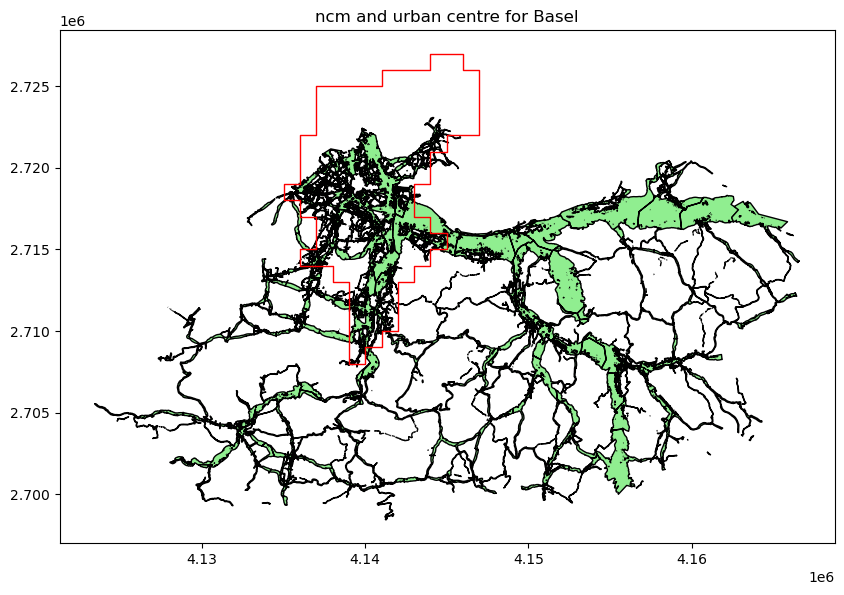

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt



# Plotting the two GeoDataFrames
fig, ax = plt.subplots(figsize=(10, 10))
ncm.plot(ax=ax, color='lightgreen', edgecolor='black')
uc_city.plot(ax=ax, edgecolor='red', color='none')

# Customize the plot (optional)
ax.set_title('ncm and urban centre for Basel')
plt.show()

In [60]:
ncm_agl

,noisy,agglomerationId_identifier,agglomerationName_nameEng,geometry


In [61]:
if ncm_agl.empty:
    print('ncm not available')

ncm not available


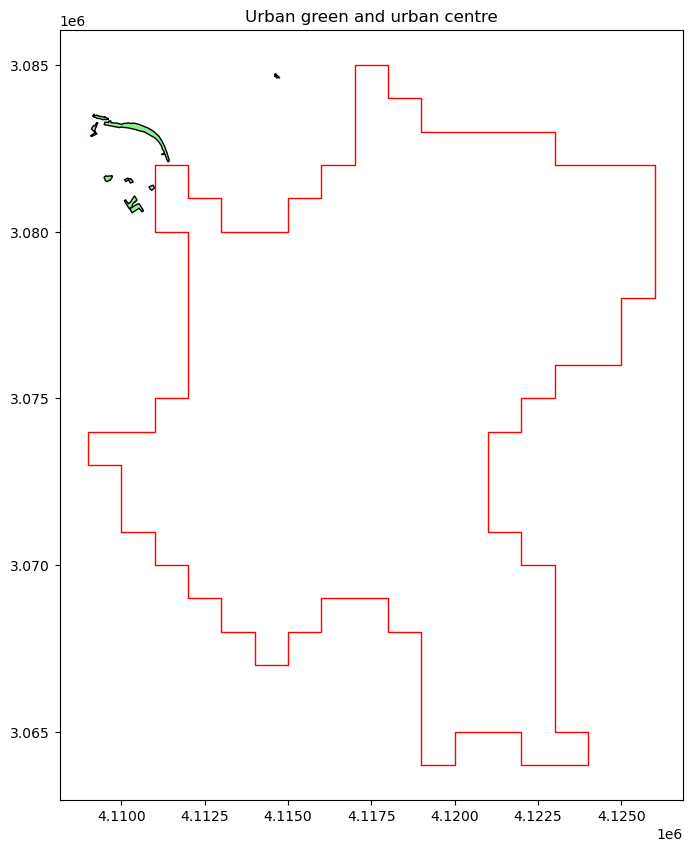

In [46]:
import geopandas as gpd
import matplotlib.pyplot as plt



# Plotting the two GeoDataFrames
fig, ax = plt.subplots(figsize=(10, 10))
uagreen.plot(ax=ax, color='lightgreen', edgecolor='black')
uc_city.plot(ax=ax, edgecolor='red', color='none')

# Customize the plot (optional)
ax.set_title('Urban green and urban centre')
plt.show()


In [49]:
if not nqgreen.empty:
    print('not empty')

In [50]:
if nqgreen.empty:
    print('empty')

empty


In [12]:
counter= 1
agl_error_ls = []


# Loop through test cities
for uc_city_code in cities_ls[14:15]:
    print(counter)
    start_time = datetime.now()
    print(str(start_time))
    #urban centre boundary delineation
    uc_city = uc_sel.query(f"HDENS_CLST=='{uc_city_code}'")
    print(uc_city.HDENS_NAME)

1
2024-07-25 18:48:58.008944
313    Basel
Name: HDENS_NAME, dtype: object
